# Домашнее задание 5. Линейные модели

In [1]:
import random as pr
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import sklearn.cross_validation as cv
import sklearn.metrics as sm

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Зачитываем результат 4 домашки

In [2]:
data = np.load("out_4.dat.npz")
users = data["users"]
X_dataset = data["data"].reshape(1,)[0]

In [3]:
X_dataset.shape

(6898, 164790)

Зачитываем категории пользователей

In [4]:
TRAINING_SET_URL = "twitter_train.txt"
EXAMPLE_SET_URL = "twitter_example.txt"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0)
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0)
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex])

Модель строим для пользователей из twitter_train, нужно выбрать этих пользователей из матрицы из 4 ДЗ:

In [5]:
# TODO check this code
train_users = df_users_train["uid"].values
ix = np.in1d(users, train_users).reshape(users.shape) #можно np.in1d(users, train_users)
X = X_dataset[np.where(ix)] #можно X_dataset[ix]

In [6]:
np.array_equal(X_dataset[np.where(ix)].toarray(), X_dataset[ix].toarray())

True

In [7]:
X_dataset[np.where(ix)].toarray().shape

(5000, 164790)

In [8]:
X_dataset[ix].toarray().shape

(5000, 164790)

In [9]:
np.array_equal(np.in1d(users, train_users), np.in1d(users, train_users).reshape(users.shape))

True

In [10]:
np.in1d(users, train_users).shape

(6898,)

In [12]:
np.in1d(users, train_users).reshape(users.shape).shape

(6898,)

Формируем целевую переменную: Делаем join списка пользователей из ДЗ4 с обучающей выборкой.

In [13]:
Y = df_users_train['cat'].values
print "Resulting training set: (%dx%d) feature matrix, %d target vector" % (X.shape[0], X.shape[1], Y.shape[0])

Resulting training set: (5000x164790) feature matrix, 5000 target vector


Чтобы исследовать, как ведут себя признаки, построим распределение количества ненулевых признаков у пользователей, чтобы убедиться, что он удовлетворяет закону Ципфа. Для этого построим гистограмму в логарифмических осях. [Подсказка](http://anokhin.github.io/img/sf1.png)

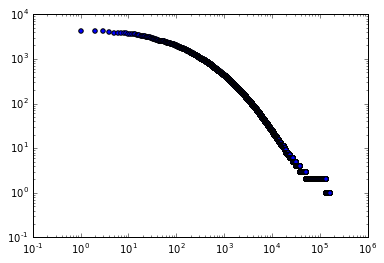

In [14]:
def draw_log_hist(x):
    """Draw tokens histogram in log scales"""
    
    # Your code here
    features_counts = (X.toarray()!=0).sum(axis = 0) + 1
    plt.xscale('log')
    plt.yscale('log')
    plt.scatter(xrange(1, x.shape[1]+1), sorted(features_counts, reverse=True))
    return features_counts

features_counts = draw_log_hist(X)

Проведем отбор признаков. В самом простом случае просто удаляем признаки, имеющие ненулевое значение у менее, чем 100 пользователей.

In [15]:
X1 = X.tocsc()[:, features_counts > 260].toarray()

Вариант задания генерируется на основании вашего ника в техносфере.

In [16]:
USER_NAME = "m.belyalova"
OPTIMIZATION_ALGORITHMS = ["stochastic gradient descent", "Newton method"]
REGULARIZATIONS = ["L1", "L2"]

print "My homework 5 algorithm is: Logistic regression with %s regularization optimized by %s" % (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    OPTIMIZATION_ALGORITHMS[hash(USER_NAME[::-1]) % 2]
)

My homework 5 algorithm is: Logistic regression with L2 regularization optimized by Newton method


Реализуем выбранный алгоритм

In [26]:
from numpy.linalg import inv
from __future__ import division

class LogisticRegression():
    def __init__(self, max_iter=100, C=1000, step=1):
        self.max_iter = max_iter
        self.C = C
        self.step = step
    
    def mnk(self, x, y, w=None):
        if w == None:
            w = np.zeros(x.shape[1])
        inverted_hessian = inv(np.dot(x.T, x) + np.eye(x.shape[1]) * 2 * self.C)
        grad_vector_with_l2 = np.dot(x.T, y) - 2 * self.C * w
        return np.dot(inverted_hessian, grad_vector_with_l2)
        #return np.dot(np.dot(inv(np.dot(X.T, X)), X.T), y)

    def sigma(self, z):
        return 1 / (1 + np.exp(-z))

    def Newton_IRLS(self, X, Y):
        #w = np.dot(inv(np.dot(self.X.T, self.X)), np.dot(self.X.T, self.Y))   
        w = self.mnk(X, Y)
        self.iters.append(w)
        #pred_sigmas = np.zeros(self.X.shape[0])
        for t in range(0, self.max_iter):
            z = np.dot(X, w)
            zy = np.multiply(z, Y)          
            sigmas = self.sigma(zy)
            weights = np.sqrt((1 - sigmas) * sigmas)
    
            X_weighted = np.dot(np.diag(weights), X)
            y_weighted = np.multiply(Y, np.sqrt((1 - sigmas) / sigmas))
            
            #w_iter = np.dot(inv(np.dot(X_weighted.T, X_weighted)), np.dot(X_weighted.T, y_weighted) - self.C)
            #w = w + step_t * w_iter
            old_w = w
            w = w + self.step * self.mnk(X_weighted, y_weighted, w)
            if np.isnan(w[0]):
                print 'Iteration method with such parameters doesn\'t converge :('
                return old_w
            
            self.iters.append(w)
            
            #if np.linalg.norm(sigmas - pred_sigmas) < self.eps:
                #break
            #pred_sigmas = sigmas
        return w
    
    def fit(self, X, Y=None):
        classes = np.unique(Y).tolist()
        if len(classes) != 2:
            raise ValueError('This classifier handles only two-class classification :(')
        if classes != [-1, 1]:
            Y = numpy.where(np.copy(Y) == classes[0], -1, np.copy(Y))
            Y = numpy.where(np.copy(Y) == classes[1], 1, np.copy(Y))
        X = np.hstack((X, np.ones(X.shape[0])[:,np.newaxis]))
        self.iters = []
        #self.X = X
        #self.Y = Y
        self.w = self.Newton_IRLS(X, Y)
        print 'Classifier was fitted :)'
        return self
    
    def predict_proba(self, x):
        x = np.hstack((x, np.ones(x.shape[0])[:,np.newaxis]))
        proba = 1 - 1 / (1 + np.exp(-x.dot(self.w[:,np.newaxis])))
        proba = np.hstack((proba, 1/(1 + np.exp(-x.dot(self.w)))[:,np.newaxis]))
        print 'Data was predicted :)'
        return proba

Реализуем метрику качества, используемую в соревновании: площадь под ROC кривой

In [20]:
from __future__ import division

def auroc(y_prob, y_true):
    m_minus = (y_true == 0).sum()
    m_plus = (y_true == 1).sum()
    
    sorted_by_prob = sorted(zip(y_true, y_prob), key=lambda tup: tup[1], reverse=True)
    sorted_y_true = zip(*sorted_by_prob)[0]
    
    fp, tp = 0, 0
    fpr, tpr = [], []
    f_prev = -inf
    auc = 0
    
    for i in range(1, len(sorted_y_true)):
        if y_prob[i] != f_prev:
            fpr_i = fp / m_minus
            fpr.append(fpr_i)
            tpr_i = tp / m_plus
            tpr.append(tpr_i)
            f_prev = y_prob[i]
        if y_true[i] == 1:
            tp += 1
        else:
            fp += 1
            auc += 1 / m_minus * tpr[-1]
    return fpr, tpr, auc

Разделим выборку с помощью методики кросс-валидации для того, чтобы настроить параметр регуляризации $C$

In [30]:
from sklearn.cross_validation import KFold

def cross_validation_score(model, X, Y):
    kf = KFold(X1.shape[0], n_folds=10)
    rocs = []
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        model.fit(X_train, y_train)
        prob_pos = model.predict_proba(X_test)[:, 1]
        #prob_pos[prob_pos > 0.5] = 1
        #prob_pos[prob_pos <= 0.5] = 0
        roc_auc = auroc(prob_pos, y_test)[2]
        rocs.append(roc_auc)
    return rocs

In [31]:
C = [0.0, 0.01, 0.1, 1, 10, 100, 1000, 10000]

def select_reg_parameter(C, X, Y):
    best_accuracy = 0
    best_c_ind = -1
    best_c = -1
    for c in C:
        model = LogisticRegression(C=c)
        print "Trying model with C=" + str(c)
        score = cross_validation_score(model, X, Y)
        print score
        accuracy = numpy.mean(score)
        print "Accuracy: " + str(accuracy)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_c_ind = C.index(c)
            best_c = c
    print "Best accuracy: " + str(best_accuracy)
    print "Best parameter: " + str(best_c)
    return best_c_ind

index = select_reg_parameter(C, X1, Y)
print index

Trying model with C=0.0
Classifier was fitted :)
Data was predicted :)
Classifier was fitted :)
Data was predicted :)
Classifier was fitted :)
Data was predicted :)
Classifier was fitted :)
Data was predicted :)
Classifier was fitted :)
Data was predicted :)
Classifier was fitted :)
Data was predicted :)
Classifier was fitted :)
Data was predicted :)
Classifier was fitted :)
Data was predicted :)
Classifier was fitted :)
Data was predicted :)
Classifier was fitted :)
Data was predicted :)
[0.60503072196620589, 0.5939975990396158, 0.55687074829931971, 0.63680084643870527, 0.54761904761904756, 0.60497596153846156, 0.58688020006733033, 0.56333808615966285, 0.57868333039957753, 0.57042850742447515]
Accuracy: 0.584462504895
Trying model with C=0.01
Classifier was fitted :)
Data was predicted :)
Classifier was fitted :)
Data was predicted :)
Classifier was fitted :)
Data was predicted :)
Classifier was fitted :)
Data was predicted :)
Classifier was fitted :)
Data was predicted :)
Classifier 

/Users/masha/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Выбираем наилучшее значение $C$, и классифицируем неизвестных пользователей и строим ROC-кривую

Classifier was fitted :)
Data was predicted :)
Area under the ROC curve : 0.704683


/Users/masha/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


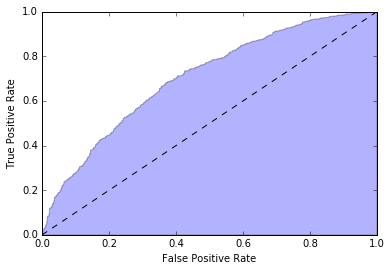

In [39]:
def classify(X, Y, test_size, C):
    
    train_samples = int((1 - test_size)*Y.shape[0])

    X_train = X1[:train_samples]
    X_test = X1[train_samples:]
    y_train = Y[:train_samples]
    y_test = Y[train_samples:]
    
    lr = LogisticRegression(C=C)
    lr.fit(X_train, y_train)
    prob_pos = lr.predict_proba(X_test)[:, 1]
    
    roc_auc = auroc(prob_pos, y_test)[2]
    tpr = auroc(prob_pos, y_test)[1]
    fpr = auroc(prob_pos, y_test)[0]
    
    return tpr, fpr, roc_auc

tpr, fpr, roc_auc = classify(X1, Y, 0.3, C[index])

print "Area under the ROC curve : %f" % roc_auc

def plot_roc_curve(tpr, fpr, roc_auc):
    """Plot ROC curve"""
    
    # Your code here
    plt.fill_between(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    pass

plot_roc_curve(tpr, fpr, roc_auc)

С помощью полученной модели предсказываем категории для неизвестных пользователей из соревнования и загружаем на kaggle в нужном формате. ДЗ принимается только при наличии загруженных данных на kaggle.